#### In this work, we're going to try to predict noisy MNIST images using AutoEncoder.
#### You can reach the guide from https://keras.io/examples/vision/autoencoder/

### Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

### Setup

In [2]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    
    """
    There 60.000 images in shape of 28x28 each of them have the value from 0 to 255
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array, n_factor):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = n_factor
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

### Get the data from *keras.dataset* and split them into two part such as Original data and Noisy data

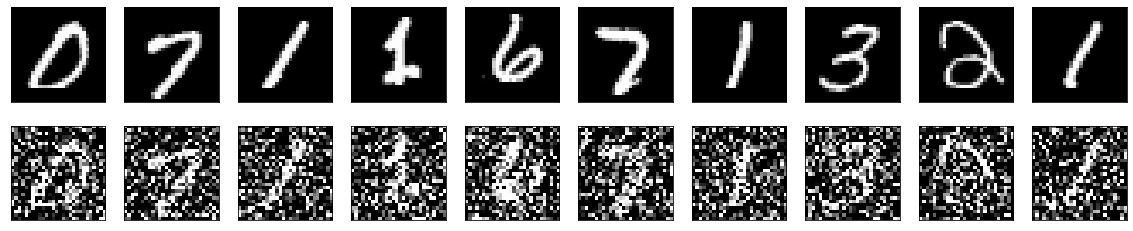

In [12]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data, 0.7)
noisy_test_data = noise(test_data, 0.7)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

***

### We're going to build our Auto Encdoer

We'll have Encoder and Decoder parts in our AutoEncoder CNN. There'll be two layers in Encoder and two layers in Decoder

In [13]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        9248

#### Now we'll train our AutoEncoder with *training_data*. It's going to be input data and target data at the same time. We're going to try to learn from that dataset and then try to predict it. Then we'll try our AutoEncoder model's accuracy with *test_data*

In [14]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1369 - val_loss: 0.0727
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0713 - val_loss: 0.0692
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0691 - val_loss: 0.0680
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0679 - val_loss: 0.0671
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0672 - val_loss: 0.0664
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0666 - val_loss: 0.0660
Epoch 7/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0662 - val_loss: 0.0657
Epoch 8/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0658 - val_loss: 0.0653
Epoch 9/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0655 - val_loss: 0.0650
Epoch 10/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0653 - val_lo

***
Let's predict on our test dataset and display the original image together with the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although not quite the same.

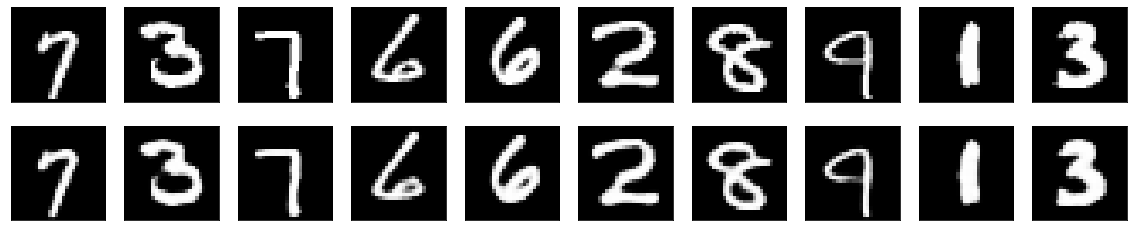

In [15]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

***
Now we tested our AutoEncoder with the original dataset and see it works. Let's try to train the AutoEncoder with *noisy data* and try to predict the original ones.

In [16]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1513 - val_loss: 0.1398
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1387 - val_loss: 0.1363
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1359 - val_loss: 0.1340
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1340 - val_loss: 0.1327
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1326 - val_loss: 0.1315
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1316 - val_loss: 0.1309
Epoch 7/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1307 - val_loss: 0.1299
Epoch 8/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1299 - val_loss: 0.1289
Epoch 9/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1293 - val_loss: 0.1287
Epoch 10/10
469/469 [==============================] - 9s 19ms/step - loss: 0.1287 - val_lo

### Let's see how it works with noisy data

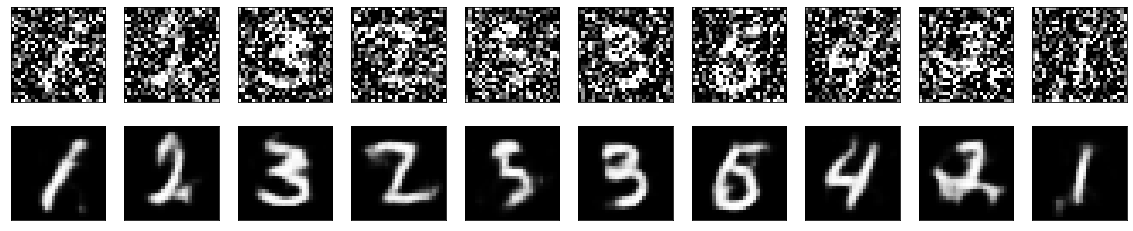

In [17]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

<div class="alert alert-block alert-warning">
<b>Note:</b> We can try to increase noise coefficient and try to look for results again
</div>